<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/CMAB_movielens_neural_egreedy_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-agents -q

In [2]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-18 12:53:57--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3657 (3.6K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   3.57K  --.-KB/s    in 0s      

2021-02-18 12:53:57 (42.3 MB/s) - ‘./utils.py’ saved [3657/3657]



In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
import tensorflow_probability as tfp
import zipfile

from tqdm.notebook import trange
from typing import Optional, Sequence, Text, Tuple

from tf_agents.bandits.agents import linear_bandit_agent as lin_agent
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.policies import linalg
from tf_agents.bandits.policies import linear_bandit_policy
from tf_agents.bandits.policies import policy_utilities
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import array_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types

from utils import load_movielens_data, plot_regret

In [4]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-18 12:54:00--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  3.55MB/s    in 1.3s    

2021-02-18 12:54:02 (3.55 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



In [43]:
EPSILON = 0.05 # @param {type: "number"}
LR = 0.005 # @param {type: "number"}
NUM_ACTIONS = 20 # @param {type:"integer"}
RANK_K = 20 # @param {type:"integer"}
LAYERS = (50, 50, 50)

## Environment

In [6]:
class MovieLensPyEnvironment(bandit_py_environment.BanditPyEnvironment):
  """Implements the MovieLens Bandit environment.
  This environment implements the MovieLens 100K dataset, available at:
  https://www.kaggle.com/prajitdatta/movielens-100k-dataset
  This dataset contains 100K ratings from 943 users on 1682 items.
  This csv list of:
  user id | item id | rating | timestamp.
  This environment computes a low-rank matrix factorization (using SVD) of the
  data matrix A, such that: A ~= U * V.
  The reward of recommending item `j` to user `i` is provided as A_{ij}.
  """

  def __init__(self,
               data_dir: Text,
               rank_k: int,
               batch_size: int = 1,
               num_movies: int = 20,
               name: Optional[Text] = 'movielens'):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
      name: The name of this environment instance.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    #self._data_matrix = dataset_utilities.load_movielens_data(data_dir)
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)

    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size, dtype=np.int32)
    self._previous_users = np.zeros(batch_size, dtype=np.int32)

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(),
        dtype=np.int32,
        minimum=0,
        maximum=self._num_actions - 1,
        name='action')
    observation_spec = array_spec.ArraySpec(
        shape=(self._context_dim,), dtype=np.float64, name='observation')
    self._time_step_spec = ts.time_step_spec(observation_spec)
    self._observation = np.zeros((self._batch_size, self._context_dim))

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)

    super(MovieLensPyEnvironment, self).__init__(
        observation_spec, self._action_spec)

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def batched(self):
    return True

  def _observe(self):
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def _apply_action(self, action):
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

In [7]:
env = MovieLensPyEnvironment('./ml-100k/u.data', RANK_K, 8, num_movies=NUM_ACTIONS)
tf_env = tf_py_environment.TFPyEnvironment(env)

In [8]:
print('Observation spec:', tf_env.observation_spec())
print('An observation: ', tf_env.reset().observation.numpy())

action = tf.zeros(8, dtype=tf.int32)
time_step = tf_env.step(action)

print()
print(f'Action={action.numpy()} (optimal={tf_env.compute_optimal_action()})')
print(f'Reward={time_step.reward.numpy()} (optimal={tf_env.compute_optimal_reward()})')

Observation spec: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
An observation:  [[-3.94529398e-01  6.19882151e-01  1.78123410e-01 -9.37601298e-02
   5.51991761e-01  3.74200561e-01  3.83084043e-01 -9.76556973e-02
  -2.64710167e-02 -2.12632561e-01  1.67813904e-01 -1.24347715e-01
   2.10706751e-04  4.05566171e-02 -5.50542142e-02 -9.30046044e-01
  -2.22524018e-01  4.89419567e-01  2.35727677e-01  2.93585260e-02]
 [-7.10297503e-01 -6.49063287e-01 -3.11386143e-01  1.95962636e-01
   2.56765610e-01 -9.38611446e-03  9.15136811e-02 -5.63975227e-02
  -8.31958560e-02  2.61307398e-01 -1.17603517e-02 -3.10110648e-01
  -1.44680322e-01  3.88435376e-03  1.73411727e-01 -1.41490506e-02
  -5.80735686e-02 -3.77387714e-02 -8.45181577e-03  1.98401308e-02]
 [-6.29400884e-01 -7.20472201e-01  1.10117026e-01 -3.22535795e-01
  -4.19614787e-01  6.40935619e-02  6.58513859e-02 -1.84897567e-01
  -6.21698404e-02  1.44678250e-01 -2.19038824e-02 -3.10440087e-02
  -8.94964810e-02  6.80593978e-01 -3.294735

## Policy

## Agent

In [9]:
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.networks import q_network

In [10]:
def get_agent(
    environment, 
    layers: Tuple[int] = LAYERS, 
    lr: float = LR, 
    epsilon: float = EPSILON
  ):
  network = q_network.QNetwork(
            input_tensor_spec=environment.time_step_spec().observation,
            action_spec=environment.action_spec(),
            fc_layer_params=layers)
  
  return eps_greedy_agent.NeuralEpsilonGreedyAgent(
      time_step_spec=environment.time_step_spec(),
      action_spec=environment.action_spec(),
      reward_network=network,
      optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=lr),
      epsilon=epsilon)

In [11]:
agent = get_agent(tf_env, layers=LAYERS, lr=LR, epsilon=EPSILON)

In [12]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=TensorSpec(shape=(20,), dtype=tf.float64, name='observation'), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)), policy_info=PolicyInfo(log_probability=(), predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))


In [13]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  TensorSpec(shape=(20,), dtype=tf.float64, name='observation')


## Experiment

In [14]:
def run(
    environment, 
    agent, 
    iterations, 
    steps_per_loop,
    additional_metrics=()
):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.policy.trajectory_spec,
      batch_size=environment.batch_size,
      max_length=steps_per_loop)
  
  metrics = [] + list(additional_metrics)
  ret_metrics = dict([(m.name, []) for m in metrics])

  observers = [replay_buffer.add_batch] + metrics

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=steps_per_loop * environment.batch_size,
      observers=observers)

  regret_values = []

  for _ in trange(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    # Log metrics value
    for metric in metrics:
      ret_metrics[metric.name].append(metric.result())

  return ret_metrics

In [15]:
def get_metrics(environment):
  optimal_reward_fn = functools.partial(
        environment_utilities.compute_optimal_reward_with_movielens_environment,
        environment=tf_env)
  optimal_action_fn = functools.partial(
        environment_utilities.compute_optimal_action_with_movielens_environment,
        environment=tf_env)
  
  regret_metric = tf_bandit_metrics.RegretMetric(
      optimal_reward_fn, 
      name='regret'
  )
  suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn,
      name='suboptimal_arms'
  )
  
  return [regret_metric, suboptimal_arms_metric]

In [50]:
batch_size =   128# @param {type:"integer"}
num_iterations =   500# @param {type:"integer"}
steps_per_loop =   128# @param {type:"integer"}
agent_alpha = 10.0  # @param {type: "number"}

env = MovieLensPyEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K,
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS
)
tf_env = tf_py_environment.TFPyEnvironment(env)
tf_env.reset()

agent = get_agent(tf_env, layers=LAYERS, lr=LR, epsilon=EPSILON)

additional_metrics = get_metrics(tf_env)

metrics = run(
    tf_env, 
    agent, 
    iterations=num_iterations,
    steps_per_loop=steps_per_loop,
    additional_metrics=additional_metrics
)

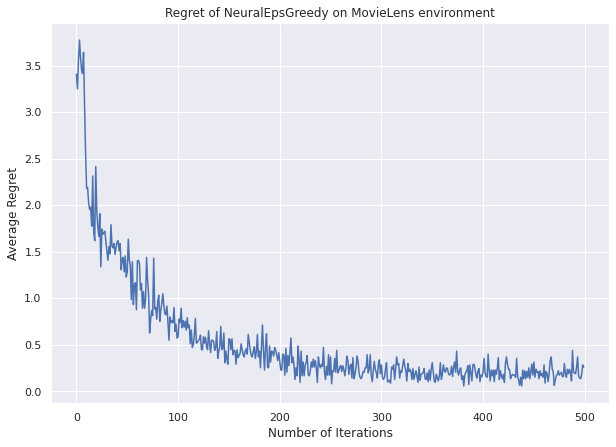

In [51]:
plot_regret(metrics['regret'], {'algorithm': 'NeuralEpsGreedy'})

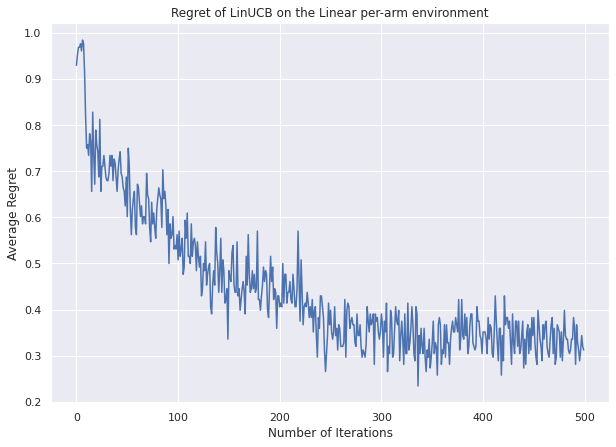

In [52]:
plt.figure(figsize=(10, 7))
plt.plot(metrics['suboptimal_arms'])
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')